In [1]:
import warnings
warnings.filterwarnings("ignore")
import joblib

import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
import json
import copy
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_tree
import pandas as pd
from sklearn import metrics
from sklearn2pmml import PMMLPipeline
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn2pmml import sklearn2pmml
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, Imputer, LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn2pmml.preprocessing import FeatureBinarizer
from sklearn2pmml import sklearn2pmml
from work.marvin.binary_classification_evaluation import binaryClassEvaluationPlots as evl
from work.marvin.binary_classifier_models import modelfit, modelDiagnose
from work.marvin.binary_classifier_models import bestLightgbmModelProducer

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import pickle 

# read data

In [2]:
# read file
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [3]:
# kick out pstime > order_time
# kick out petime > order_time
print(train.shape)

idx = (train['pstime'] <= train['order_time']) & (train['petime'] <= train['order_time'])
train = train[idx]
train.shape

(8534559, 10)


(5520901, 10)

In [4]:
# data check
np.sum(~(train['pstime'] <= train['petime']))

3187

In [5]:
train = train[train['pstime'] <= train['petime']]

In [6]:
# train = train.loc[:30]
# train

In [7]:
# prepare data format

from datetime import datetime
def convert_to_date(train):
    # convert time to timestamp
    train['pstime'] = (train['pstime']//1000).apply(lambda x: datetime.fromtimestamp(x))
    train['petime'] = (train['petime']//1000).apply(lambda x: datetime.fromtimestamp(x))
    train['order_time'] = (train['order_time']/1000).apply(lambda x: datetime.fromtimestamp(x))
    return train

# duration time(second) for each action
train['duration'] = (train['petime'] - train['pstime'])/1000
# time -> date
train = convert_to_date(train)

# get small sample for debug

In [8]:
gb = train.groupby(['user_id', 'order_time'])
data = []

cnt = 0
for name, group in gb:
    
    print(cnt)
    group = group.sort_values(['pstime'])
    group.index = range(len(group))
    data.append((name, group))
    cnt = cnt + 1
    if cnt > 20:
        break
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


# feature engeering

In [9]:
# # agenda
# for each group:
#     # get windowed(15days, 1 month) data
    
#     # do statistical features
#     1.get statistics features for duration,
#     2.get statistics features for duration of different pages,
#     # statistic features include:
#         1.count, sum, mean,  
#         2.trends: std, absolute change, absoluate energy, fit coefs
#         3.rate:占比(还没做)

### get windowed data

In [10]:
# data[1][1][['pstime', 'duration', 'pname']]

In [11]:
data[1][0]

('00008a736dcc4d099436cda07d41bdc4', Timestamp('2017-10-21 18:03:00'))

In [12]:
def window_data(group, ts, size=30):   
    # get windowed ts
    idx = ((group['order_time']-group['pstime']).apply(lambda x: x.days<size)) & \
    ((group['order_time']-group['petime']).apply(lambda x: x.days<size))
    ts_wind = ts[idx]
    return ts_wind

# [window_data(data[i][1], data[i][1].duration) for i in range(len(data))]
# window_data(data[1][1], data[1][1].duration)

In [13]:
# page names
page_types = np.unique(train['pname'])
page_types

array(['bind_debit_card', 'biometric_auth', 'biometric_auto',
       'contacts_info', 'id_verify', 'loan_index', 'loan_submission',
       'login', 'operator', 'personal_info', 'register'], dtype=object)

In [14]:
def get_page_data(group, ts, page_name):
    idx = group['pname']==page_name
    ans = ts[idx]
    return ans
# for p in page_types:
#     print([get_page_data(data[i][1], data[i][1].duration, p) for i in range(len(data))])
#     print('\n')
get_page_data(data[1][1], data[1][1].duration,  'login')

0     12.451
17    12.272
Name: duration, dtype: float64

### get features

In [15]:
ts = data[1][1].duration
# ts

In [16]:
def basic_feats(ts):
    # special case
    if len(ts)==0:
        return [np.nan for i in range(7)]
    # normal case
    count_ = len(ts)
    sum_ = np.sum(ts)
    mean_ = np.mean(ts)
    min_ = np.min(ts)
    max_ = np.max(ts)
    q25 = np.quantile(ts, 0.25)
    q75 = np.quantile(ts, 0.75)
    return [count_, sum_, mean_, min_, max_, q25, q75]

# ts = [1,2,3,4,5]
basic_feats(ts)

[26, 538.928, 20.728, 0.392, 369.141, 3.0180000000000002, 9.69175]

In [17]:
def trends_feature(ts):
    # special case
    if len(ts) == 0:
        return [np.nan,np.nan,np.nan]
    # normal case
    std_ = np.std(ts)
    abs_change = np.sum(np.diff(ts))
    abs_energy = np.sum([i*i for i in ts])
    return [std_, abs_change, abs_energy]

# trends_feature(ts)

In [18]:
# trend advance eatures
def trends_adv_feats(x, chunk_size=2):
    # too short for agg
    if len(x) < chunk_size:
        return [np.nan,np.nan]
    # do aggregation
    aggs = []
    for i in range(len(x)-chunk_size):
        dat = x[i*chunk_size:(i+1)*chunk_size]
        if len(dat) != 0:
            aggs.append(np.mean(dat))

    n = len(aggs)
    # special case, singular matrix
    if  n==0:
        return [np.nan,np.nan]
    if n==1:
        return [np.nan,np.nan]
    
    # nonsepcial case
    aggs = np.array(aggs).reshape(-1,1)
    A = np.linspace(1, n, n).reshape(-1,1)
    A = np.hstack([np.ones(n).reshape(-1,1),A])
#     print(A)
    # solve equations
    solu = (np.linalg.inv(A.T@A))@ (A.T@aggs)
    intercept = solu[0,0]
    slope = solu[1,0]
    return [intercept, slope]


# x = [1,2,3,4,5]
trends_adv_feats(ts)

[17.502807692307684, 0.4607417582417632]

In [19]:
def _get_feats(ts):
    # basic features
    bas_feats = basic_feats(ts)
    
    # trend features
    tre_feats = trends_feature(ts)
    treadv_feats_2 = trends_adv_feats(ts,2)
    treadv_feats_5 = trends_adv_feats(ts,5)
    
    features = bas_feats + tre_feats + treadv_feats_2 + treadv_feats_5
    return features


In [20]:
def get_feature(group, col, size=15):
    # get features for each group
    feature = []
    
    ts = group[col]
    # get windowed ts
    ts = window_data(group, ts, size)
    feature.extend(_get_feats(ts))
    
    # split ts by page_name and extract features in the same way
    for page_name in page_types:
        sub_ts = get_page_data(group, ts, page_name)
        
        add_feats = _get_feats(sub_ts)
#         print(page_name, sub_ts, add_feats)
        feature.extend(add_feats)
    return feature    

# feats = get_feature(data[1][1], 'duration')
# feats

In [21]:
def get_feature_names(window_size):
    names = []
    basic_names = ['count', 'sum', 'mean','min', 'max', 'q25', 'q75', 'std','abs_change', 'abs_energy', 'intercept_2', 'slope_2', 'intercept_5', 'slope_5']
    names.extend(basic_names)
    
    # names for each page
    for p in page_types:
        nam_ = [p+'.'+i for i in basic_names]
        names.extend(nam_)
    names = [window_size+'.'+i for i in names]
    return names
col_names = get_feature_names('fifteen_days') + get_feature_names('thirty_days')
col_names

['fifteen_days.count',
 'fifteen_days.sum',
 'fifteen_days.mean',
 'fifteen_days.min',
 'fifteen_days.max',
 'fifteen_days.q25',
 'fifteen_days.q75',
 'fifteen_days.std',
 'fifteen_days.abs_change',
 'fifteen_days.abs_energy',
 'fifteen_days.intercept_2',
 'fifteen_days.slope_2',
 'fifteen_days.intercept_5',
 'fifteen_days.slope_5',
 'fifteen_days.bind_debit_card.count',
 'fifteen_days.bind_debit_card.sum',
 'fifteen_days.bind_debit_card.mean',
 'fifteen_days.bind_debit_card.min',
 'fifteen_days.bind_debit_card.max',
 'fifteen_days.bind_debit_card.q25',
 'fifteen_days.bind_debit_card.q75',
 'fifteen_days.bind_debit_card.std',
 'fifteen_days.bind_debit_card.abs_change',
 'fifteen_days.bind_debit_card.abs_energy',
 'fifteen_days.bind_debit_card.intercept_2',
 'fifteen_days.bind_debit_card.slope_2',
 'fifteen_days.bind_debit_card.intercept_5',
 'fifteen_days.bind_debit_card.slope_5',
 'fifteen_days.biometric_auth.count',
 'fifteen_days.biometric_auth.sum',
 'fifteen_days.biometric_auth.me

In [1]:
from tqdm import tqdm
def get_all_features(gb, num_obs=10000):
    all_feature = []
    key = []
    cnt = 0
    for name, group in tqdm(gb):
#         print(cnt)
        # group dataframe
        group = group.sort_values(['pstime'])
        group.index = range(len(group))
        
        # feature extraction based on duration
        feat_duration_15day = get_feature(group, 'duration',size=15) 
        feat_duration_30day = get_feature(group, 'duration',size=30) 
        # feature extraction based on order_time-pstime
        
        all_feature.append(feat_duration_15day+feat_duration_30day)
        key.append(list(name))
        cnt += 1
        if cnt > num_obs:
            break
            
    return all_feature, key


gb = train.groupby(['user_id', 'order_time']) # make group object
all_feature, key = get_all_features(gb, 20000)


In [41]:
import pickle
with open('data/all_feature2.pickle', 'wb') as f:
    pickle.dump(all_feature, f)

with open('data/key2.pickle', 'wb') as f:
    pickle.dump(key, f)

In [22]:
import pickle
with open('data/all_feature_3.pickle', 'rb') as f:
    all_feature = pickle.load(f)

with open('data/key_3.pickle', 'rb') as f:
    key = pickle.load(f)

In [24]:
# construct names
def combine_names(ts_name):
    # get colnames for each stat_item
    def get_feature_names(window_size):
        names = []
        basic_names = ['count', 'sum', 'mean', 'min', 'max','q25', 'q75',
                       'std','abs_change', 'abs_energy', 'intercept_2', 'slope_2', 'intercept_5', 'slope_5']
        names.extend(basic_names)

        # names for each page
        for p in page_types:
            nam_ = [p+'.'+i for i in basic_names]
            names.extend(nam_)
        names = [window_size+'.'+i for i in names]
        return names
    
    col_names = get_feature_names('fifteen_days') + get_feature_names('thirty_days')
    return [ts_name+'.'+i for i in col_names]

col_names = combine_names('duration') + combine_names('order_action_gap')
col_names

['duration.fifteen_days.count',
 'duration.fifteen_days.sum',
 'duration.fifteen_days.mean',
 'duration.fifteen_days.min',
 'duration.fifteen_days.max',
 'duration.fifteen_days.q25',
 'duration.fifteen_days.q75',
 'duration.fifteen_days.std',
 'duration.fifteen_days.abs_change',
 'duration.fifteen_days.abs_energy',
 'duration.fifteen_days.intercept_2',
 'duration.fifteen_days.slope_2',
 'duration.fifteen_days.intercept_5',
 'duration.fifteen_days.slope_5',
 'duration.fifteen_days.bind_debit_card.count',
 'duration.fifteen_days.bind_debit_card.sum',
 'duration.fifteen_days.bind_debit_card.mean',
 'duration.fifteen_days.bind_debit_card.min',
 'duration.fifteen_days.bind_debit_card.max',
 'duration.fifteen_days.bind_debit_card.q25',
 'duration.fifteen_days.bind_debit_card.q75',
 'duration.fifteen_days.bind_debit_card.std',
 'duration.fifteen_days.bind_debit_card.abs_change',
 'duration.fifteen_days.bind_debit_card.abs_energy',
 'duration.fifteen_days.bind_debit_card.intercept_2',
 'durati

In [25]:
len(col_names)

672

In [26]:
df = pd.DataFrame(all_feature, columns=col_names)
print(df.shape)
df.head()

(30000, 672)


,duration.fifteen_days.count,duration.fifteen_days.sum,duration.fifteen_days.mean,duration.fifteen_days.min,duration.fifteen_days.max,duration.fifteen_days.q25,duration.fifteen_days.q75,duration.fifteen_days.std,duration.fifteen_days.abs_change,duration.fifteen_days.abs_energy,...,order_action_gap.thirty_days.register.max,order_action_gap.thirty_days.register.q25,order_action_gap.thirty_days.register.q75,order_action_gap.thirty_days.register.std,order_action_gap.thirty_days.register.abs_change,order_action_gap.thirty_days.register.abs_energy,order_action_gap.thirty_days.register.intercept_2,order_action_gap.thirty_days.register.slope_2,order_action_gap.thirty_days.register.intercept_5,order_action_gap.thirty_days.register.slope_5
0,13.0,246.287,18.945154,1.459,59.225,5.1990,23.81200,17.060375,-7.651,8449.678349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24.0,525.965,21.915208,0.392,369.141,3.2485,9.47000,72.593900,-10.252,138003.617565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,177.417,11.088562,0.915,71.324,3.2820,11.62925,16.481292,-8.024,6313.427515,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27.0,239.599,8.874037,0.042,84.843,1.3080,12.07750,16.433417,-11.429,9417.754563,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,49.0,435.897,8.895857,0.017,20.912,2.2890,13.55500,6.221126,-14.188,5774.095345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
keys = pd.DataFrame(key, columns=['user_id', 'order_time'])
print(keys.shape)
keys.head()

(30000, 2)


,user_id,order_time
0,00003b4ceb224e1b977c242bbf767ea0,2017-10-25 15:59:00
1,00008a736dcc4d099436cda07d41bdc4,2017-10-08 20:18:00
2,00008a736dcc4d099436cda07d41bdc4,2017-10-22 02:03:00
3,0000c645196245c489a9bd3a0cf4a92a,2017-10-15 21:15:00
4,0000fa4f719e4f5f940823c12978116c,2017-10-19 23:44:00


In [28]:

for c in df.columns:
    zero_ratio = np.sum(df[[c]]==0)/len(df)
    print(zero_ratio)

duration.fifteen_days.count    0.0
dtype: float64
duration.fifteen_days.sum    0.0
dtype: float64
duration.fifteen_days.mean    0.0
dtype: float64
duration.fifteen_days.min    0.0
dtype: float64
duration.fifteen_days.max    0.0
dtype: float64
duration.fifteen_days.q25    0.0
dtype: float64
duration.fifteen_days.q75    0.0
dtype: float64
duration.fifteen_days.std    0.0065
dtype: float64
duration.fifteen_days.abs_change    0.0065
dtype: float64
duration.fifteen_days.abs_energy    0.0
dtype: float64
duration.fifteen_days.intercept_2    0.0
dtype: float64
duration.fifteen_days.slope_2    0.0
dtype: float64
duration.fifteen_days.intercept_5    0.0
dtype: float64
duration.fifteen_days.slope_5    0.0
dtype: float64
duration.fifteen_days.bind_debit_card.count    0.0
dtype: float64
duration.fifteen_days.bind_debit_card.sum    0.0
dtype: float64
duration.fifteen_days.bind_debit_card.mean    0.0
dtype: float64
duration.fifteen_days.bind_debit_card.min    0.0
dtype: float64
duration.fifteen_days.

duration.thirty_days.abs_energy    0.0
dtype: float64
duration.thirty_days.intercept_2    0.0
dtype: float64
duration.thirty_days.slope_2    0.0
dtype: float64
duration.thirty_days.intercept_5    0.0
dtype: float64
duration.thirty_days.slope_5    0.0
dtype: float64
duration.thirty_days.bind_debit_card.count    0.0
dtype: float64
duration.thirty_days.bind_debit_card.sum    0.0
dtype: float64
duration.thirty_days.bind_debit_card.mean    0.0
dtype: float64
duration.thirty_days.bind_debit_card.min    0.0
dtype: float64
duration.thirty_days.bind_debit_card.max    0.0
dtype: float64
duration.thirty_days.bind_debit_card.q25    0.0
dtype: float64
duration.thirty_days.bind_debit_card.q75    0.0
dtype: float64
duration.thirty_days.bind_debit_card.std    0.034667
dtype: float64
duration.thirty_days.bind_debit_card.abs_change    0.034667
dtype: float64
duration.thirty_days.bind_debit_card.abs_energy    0.0
dtype: float64
duration.thirty_days.bind_debit_card.intercept_2    0.0
dtype: float64
durati

order_action_gap.fifteen_days.biometric_auth.q75    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auth.std    0.0058
dtype: float64
order_action_gap.fifteen_days.biometric_auth.abs_change    0.0058
dtype: float64
order_action_gap.fifteen_days.biometric_auth.abs_energy    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auth.intercept_2    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auth.slope_2    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auth.intercept_5    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auth.slope_5    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auto.count    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auto.sum    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auto.mean    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auto.min    0.0
dtype: float64
order_action_gap.fifteen_days.biometric_auto.max    0.0
dtype: float64
order_action_gap.fifteen_days.

order_action_gap.thirty_days.contacts_info.q25    0.0
dtype: float64
order_action_gap.thirty_days.contacts_info.q75    0.0
dtype: float64
order_action_gap.thirty_days.contacts_info.std    0.002733
dtype: float64
order_action_gap.thirty_days.contacts_info.abs_change    0.002733
dtype: float64
order_action_gap.thirty_days.contacts_info.abs_energy    0.0
dtype: float64
order_action_gap.thirty_days.contacts_info.intercept_2    0.0
dtype: float64
order_action_gap.thirty_days.contacts_info.slope_2    0.0
dtype: float64
order_action_gap.thirty_days.contacts_info.intercept_5    0.0
dtype: float64
order_action_gap.thirty_days.contacts_info.slope_5    0.0
dtype: float64
order_action_gap.thirty_days.id_verify.count    0.0
dtype: float64
order_action_gap.thirty_days.id_verify.sum    0.0
dtype: float64
order_action_gap.thirty_days.id_verify.mean    0.0
dtype: float64
order_action_gap.thirty_days.id_verify.min    0.0
dtype: float64
order_action_gap.thirty_days.id_verify.max    0.0
dtype: float64
ord

(array([112.,   4.,   8.,   0.,   0.,  44., 104.,  24.,  20.,  20.,   4.,
        104.,   0.,   0.,   4.,   4.,   0.,   0.,   8.,   0.,  32.,  28.,
         12.,  24., 116.]),
 array([3.33333333e-05, 4.00320000e-02, 8.00306667e-02, 1.20029333e-01,
        1.60028000e-01, 2.00026667e-01, 2.40025333e-01, 2.80024000e-01,
        3.20022667e-01, 3.60021333e-01, 4.00020000e-01, 4.40018667e-01,
        4.80017333e-01, 5.20016000e-01, 5.60014667e-01, 6.00013333e-01,
        6.40012000e-01, 6.80010667e-01, 7.20009333e-01, 7.60008000e-01,
        8.00006667e-01, 8.40005333e-01, 8.80004000e-01, 9.20002667e-01,
        9.60001333e-01, 1.00000000e+00]),
 <a list of 25 Patch objects>)

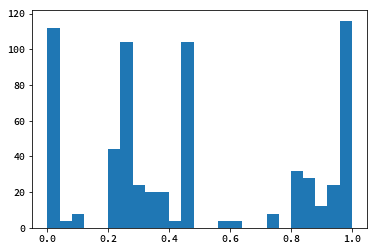

In [29]:
cov = df.isnull().sum(axis=0)/len(df)
plt.hist(cov, bins=25)

In [30]:
label = gb['label'].head(1)
label.index = range(len(label))
label

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
149839    0.0
149840    0.0
149841    1.0
149842    0.0
149843    0.0
Name: label, Length: 149844, dtype: float64

# feature selection

In [31]:
X = df
y = label.loc[:len(X)-1]
train = pd.concat([X,y], axis=1)

# split
train, test = train_test_split(train, test_size=0.25, random_state=0)
train.shape, test.shape

train.head(2)

,duration.fifteen_days.count,duration.fifteen_days.sum,duration.fifteen_days.mean,duration.fifteen_days.min,duration.fifteen_days.max,duration.fifteen_days.q25,duration.fifteen_days.q75,duration.fifteen_days.std,duration.fifteen_days.abs_change,duration.fifteen_days.abs_energy,...,order_action_gap.thirty_days.register.q25,order_action_gap.thirty_days.register.q75,order_action_gap.thirty_days.register.std,order_action_gap.thirty_days.register.abs_change,order_action_gap.thirty_days.register.abs_energy,order_action_gap.thirty_days.register.intercept_2,order_action_gap.thirty_days.register.slope_2,order_action_gap.thirty_days.register.intercept_5,order_action_gap.thirty_days.register.slope_5,label
12880,20.0,428.959,21.447950,1.814,129.062,3.5815,25.7645,28.261237,10.868,25174.241621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
14868,65.0,472.492,7.269108,0.066,35.392,1.7210,8.8740,8.196208,-2.626,7801.154340,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [32]:
temp_label = train['label']

In [33]:
# fill na with -9999
from tqdm import tqdm
def fillna_cols(df):
    for c in tqdm(df.columns):
        if df[c].dtypes == 'object':
            df[c] = df[c].fillna('CreditX-NA')
        if df[c].dtypes == 'int64' or df[c].dtypes == 'float64':
            df[c] = df[c].fillna(-9999)
    return df

train = fillna_cols(train)

100%|██████████| 673/673 [00:00<00:00, 2638.92it/s]


In [34]:
from work.marvin.feature_engineering import featureEvaluation as fe


In [35]:
# good bad odds
(train.label==0).sum()/(train.label==1).sum()

14.233581584292486

In [36]:
# coverage
cov = fe.coverage_calc(train, train.columns, mi_values= [None,'[]',-1,[],-9999,'CreditX-NA'])
cov.tail(3)

,feature_name,coverage
670,duration.fifteen_days.register.intercept_5,0.0
671,duration.fifteen_days.register.slope_5,0.0
672,duration.thirty_days.register.intercept_5,0.0


(array([144.,  68.,   8.,   4.,   4., 108.,  44., 168.,   4., 121.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

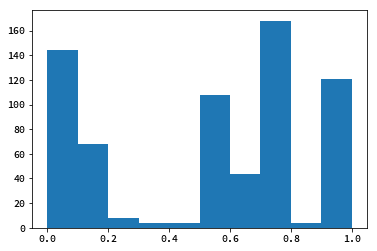

In [37]:
plt.hist(cov['coverage'])

In [38]:
ftr = cov[cov['coverage']>=0.3]['feature_name']
len(ftr)

453

In [39]:
train = train[ftr.values]

In [40]:
# iv
from tqdm import tqdm
def cal_iv_oneByone(train, total_cols):
    df_iv_list = []
    for c in tqdm(total_cols):
#         print(c)
        one =  fe.iv_calc(train[[c, 'label']],
                     colnames = [c],
                     label = 'label',
                     method = 'quantile',
                     verbose = 0)
        df_iv_list.append(one)
    return df_iv_list
    
df_iv_list = cal_iv_oneByone(train, train.columns)
len(df_iv_list)

100%|██████████| 453/453 [02:20<00:00,  4.15it/s]


453

In [41]:
with open('data/df_iv_list.pickle', 'wb') as ww:
    pickle.dump(df_iv_list,ww)

In [42]:
iv = pd.concat(df_iv_list)
iv = iv.drop_duplicates()
iv.sort_values(by = 'iv', ascending = False).head(20)
iv.head(3)

,feature_name,iv
0,order_action_gap.thirty_days.q25,0.006595
0,duration.thirty_days.mean,0.002156
0,duration.thirty_days.min,0.003958


(array([69., 92., 60., 53., 35., 28., 19., 17., 15., 21.,  6.,  4., 10.,
         3.,  5.,  2.,  1.,  3.,  2.,  2.,  2.,  2.,  0.,  0.,  1.]),
 array([0.00041706, 0.00208821, 0.00375936, 0.00543051, 0.00710166,
        0.00877281, 0.01044396, 0.01211511, 0.01378626, 0.01545741,
        0.01712856, 0.01879971, 0.02047086, 0.02214201, 0.02381316,
        0.02548431, 0.02715546, 0.02882661, 0.03049776, 0.03216891,
        0.03384005, 0.0355112 , 0.03718235, 0.0388535 , 0.04052465,
        0.0421958 ]),
 <a list of 25 Patch objects>)

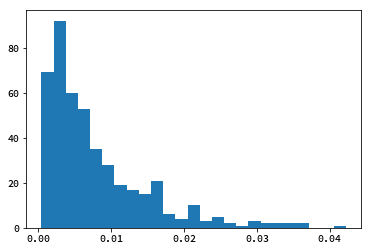

In [43]:
plt.hist(iv['iv'], bins=25)

In [44]:
ftr = iv[iv['iv']>0.01]['feature_name']
len(ftr)

120

In [45]:
train = train[list(ftr.values)]

In [46]:
train = pd.concat([train, temp_label], axis=1)

# model


In [47]:
import warnings
warnings.filterwarnings("ignore")
import joblib

import numpy as np
from datetime import datetime

from matplotlib import pyplot as plt
import json
import copy
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance, plot_tree
import pandas as pd
from sklearn import metrics
from sklearn2pmml import PMMLPipeline
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn2pmml import sklearn2pmml
from sklearn.model_selection import train_test_split
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, Imputer, LabelEncoder, StandardScaler
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer, MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import model_selection
from sklearn2pmml.preprocessing import FeatureBinarizer
from sklearn2pmml import sklearn2pmml
from work.marvin.binary_classification_evaluation import binaryClassEvaluationPlots as evl
from work.marvin.binary_classifier_models import modelfit, modelDiagnose
from work.marvin.binary_classifier_models import bestLightgbmModelProducer

In [48]:
continuousDomain = []
categoricalDomain = []
target = 'label'

for columns in train.columns:
    if columns != 'label':
        if train[columns].dtypes != object:
            continuousDomain.append(columns)
        else:
            categoricalDomain.append(columns)
            

dfm_LabelEncoder = DataFrameMapper([(continuousDomain, [ContinuousDomain(invalid_value_treatment='as_missing',
                                                                             missing_value_treatment='as_is'),Imputer()],
                                         {'union_cols': False})]
                                       +[(c,[CategoricalDomain(invalid_value_treatment='as_missing',
                                                               missing_value_treatment='as_mean',
                                                               missing_value_replacement = 'CreditX-NA'),
                                             LabelEncoder()])
                                         for c in categoricalDomain],
                                       df_out=True)

ans_LB = dfm_LabelEncoder.fit_transform(train.drop(columns=[target]), np.array(train[target]))



In [49]:
categoricalDomain

[]

In [123]:
lgbm_best_skopt = LGBMClassifier(boosting_type='gbdt', 
                                 class_weight=None,
                                 colsample_bytree=0.8, 
                                 importance_type='split',
                                 is_unbalance=True, 
                                 learning_rate=0.01, 
                                 max_bin=15,
                                 max_depth=3, 
                                 min_child_samples=500, 
                                 min_child_weight=0.001,
                                 min_split_gain=0.01, 
                                 n_estimators=1000, 
                                 n_jobs=12,
                                 num_leaves=42, 
                                 objective='binary', 
                                 random_state=27, 
                                 reg_alpha=0,
                                 reg_lambda=0, 
                                 scale_pos_weight=1, 
                                 silent=False, 
                                 subsample=0.7,
                                 subsample_for_bin=200000, 
                                 subsample_freq=2)

In [124]:
lgb_pipeline = PMMLPipeline([('dfm', dfm_LabelEncoder),('lightGBM', lgbm_best_skopt)])
lgb_pipeline.fit(train[train.columns.difference([target])], train[target])

PMMLPipeline(steps=[('dfm', DataFrameMapper(default=False, df_out=True,
        features=[(['order_action_gap.thirty_days.loan_index.min', 'duration.thirty_days.loan_index.std', 'duration.thirty_days.loan_index.abs_change', 'duration.fifteen_days.max', 'duration.thirty_days.intercept_2', 'duration.thirty_days.slope_2', 'order_action_gap.fifteen_days.loan_index.min', 'duration.f...puter(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)], {'union_cols': False})],
        input_df=False, sparse=False)),
       ('lightGBM', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', is_unbalance=True, learning_rate=0.01,
        max_bin=15, max_depth=3, min_child_samples=500,
        min_child_weight=0.001, min_split_gain=0.01, n_estimators=1000,
        n_jobs=12, num_leaves=42, objective='binary', random_state=27,
        reg_alpha=0, reg_lambda=0, scale_pos_weight=1, silent=False,
        subsample=0.7, subsample_for_


Model Report
AUC Score (Train): 0.767053
CV Score : Mean - 0.5166461 | Std - 0.006785564 | Min - 0.5093417 | Max - 0.5256881


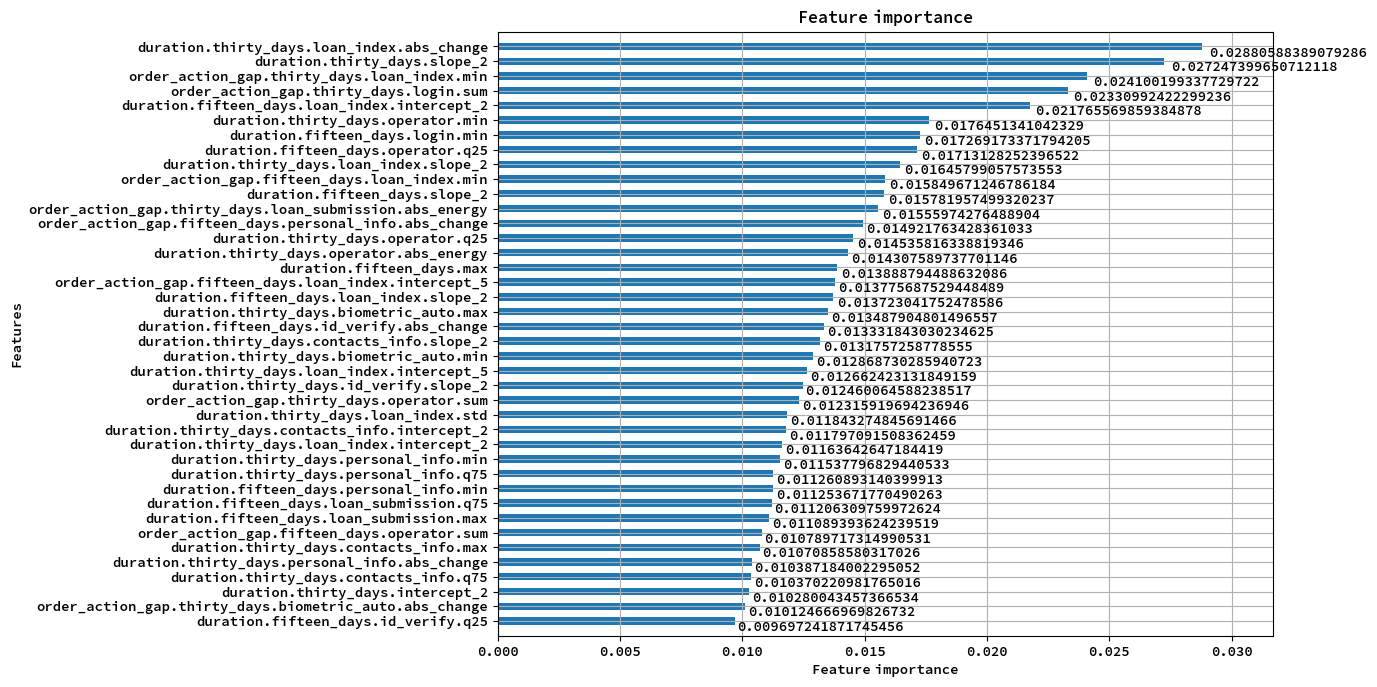

In [125]:
pipeline ,train_, predprob, auc, cv_score = modelfit.pipeline_fit(lgb_pipeline,train,target,cv=3)

In [126]:
pipeline.feature_importances_.T.head(10)

,ftr_importance
duration.thirty_days.loan_index.abs_change,0.028806
duration.thirty_days.slope_2,0.027247
order_action_gap.thirty_days.loan_index.min,0.024100
order_action_gap.thirty_days.login.sum,0.023310
duration.fifteen_days.loan_index.intercept_2,0.021766
duration.thirty_days.operator.min,0.017645
duration.fifteen_days.login.min,0.017269
duration.fifteen_days.operator.q25,0.017131
duration.thirty_days.loan_index.slope_2,0.016458
order_action_gap.fifteen_days.loan_index.min,0.015850


0.47478487229203425


(0.0684477125279267, 0.47, 0.06, 0.44)

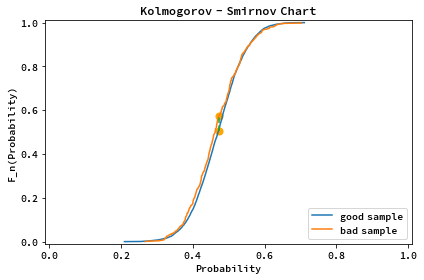

In [127]:
pipeline, test_, predprob = modelfit.pipelinePredict(lgb_pipeline, test, target)
auc = metrics.roc_auc_score(y_score=predprob['predprob'], y_true = predprob['ytrue'])
print(auc)
evl.ks_curve(Y_true = predprob['ytrue'], Y_predprob = predprob['predprob'],fig_path=None)

0.7670529530300356


(0.4034839683435342, 0.49, 0.13, 0.77)

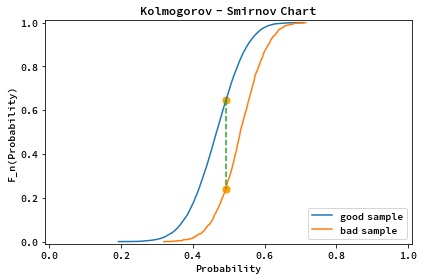

In [128]:
pipeline, train_, predprob = modelfit.pipelinePredict(lgb_pipeline, train, target)
auc = metrics.roc_auc_score(y_score=predprob['predprob'], y_true = predprob['ytrue'])
print(auc)
evl.ks_curve(Y_true = predprob['ytrue'], Y_predprob = predprob['predprob'],fig_path=None)

# LR baseline

In [56]:
X = df
y = label.loc[:len(X)-1]

# Nans
print(X.isnull().sum(axis=0))
X = X.fillna(0)

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

my_features = X
for c in my_features.columns:
    my_features[[c]] = scaler.fit_transform(my_features[[c]])
    

duration.fifteen_days.count                            169
duration.fifteen_days.sum                              169
duration.fifteen_days.mean                             169
duration.fifteen_days.min                              169
duration.fifteen_days.max                              169
                                                     ...  
order_action_gap.thirty_days.register.abs_energy     24879
order_action_gap.thirty_days.register.intercept_2    30000
order_action_gap.thirty_days.register.slope_2        30000
order_action_gap.thirty_days.register.intercept_5    30000
order_action_gap.thirty_days.register.slope_5        30000
Length: 672, dtype: int64


In [57]:
# split
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=29)
X_train.shape, X_test.shape

((22500, 672), (7500, 672))

In [58]:
from sklearn.linear_model import LogisticRegression
mod = LogisticRegression()
mod.fit(X_train, y_train)
tr_sc = mod.score(X_train, y_train)
te_sc = mod.score(X_test, y_test)
print('train score: %f | test score: %f' %(tr_sc,te_sc))

y_pred = mod.predict_proba(X_test)[:,1]


train score: 0.932889 | test score: 0.932400


(0.026417071821596028, 0.07, 0.06, 0.4)

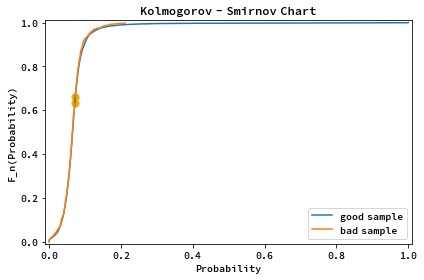

In [59]:
evl.ks_curve(y_test, y_pred, fig_path=None)